In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [1]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for f in files:
        if "data_lowF" in f:
            print(os.path.join(root, f))


In [ ]:
import torch

# =========================================================
# 実験環境ノイズ（構造化ノイズ）
# =========================================================
def process_noise(noise, clip_range=0.5, smoothing_factor=0.1):
    scaled_noise = noise / clip_range
    processed = torch.tanh(scaled_noise) * clip_range
    smoothed = processed * (1 - smoothing_factor) + noise * smoothing_factor
    return smoothed


def add_structured_noise(psd_data, clip_range=0.5, smoothing_factor=0.1):
    """
    PSD 全体に位置依存ガウスノイズを乗算的に付与
    """
    device = psd_data.device

    if psd_data.dim() == 1:
        x = psd_data.unsqueeze(0)  # (1, L)
        squeeze = True
    else:
        x = psd_data
        squeeze = False

    B, L = x.shape

    pos = torch.linspace(1, L, L, device=device)
    var = 0.2 + 0.1 * pos / 1000.0
    var = torch.clamp(var, max=0.3)
    std = torch.sqrt(var).unsqueeze(0).expand(B, L)

    noise = torch.normal(mean=0.0, std=std)
    processed = process_noise(noise, clip_range, smoothing_factor)

    noisy = x * (1.0 + processed)

    return noisy.squeeze(0) if squeeze else noisy


In [ ]:
def add_power_supply_noise(psd_data, interval_idx=0, noise_level=0.3,
                           freq_min=0.0, freq_max=15000.0):
    noisy = psd_data.clone()
    L = len(psd_data)

    freq = torch.linspace(freq_min, freq_max, L, device=psd_data.device)
    base = psd_data.mean() * noise_level

    # 50 Hz 高調波
    for h, amp in zip([1,2,3], [0.8, 0.4, 0.2]):
        f0 = 50.0 * h
        sigma = 10.0
        peak = amp * base * torch.exp(-0.5 * ((freq - f0) / sigma) ** 2)
        noisy += peak

    # 2 kHz スイッチング
    peak = 0.6 * base * torch.exp(-0.5 * ((freq - 2000.0) / 100.0) ** 2)
    noisy += peak

    return noisy, 0, L


def add_noise_to_interval(psd_data, interval_idx=0, noise_type="power_supply",
                          noise_level=0.3, freq_min=0.0, freq_max=15000.0):
    return add_power_supply_noise(
        psd_data,
        interval_idx,
        noise_level,
        freq_min,
        freq_max
    )


Device: cpu
Loaded PSD: (32000, 3000)


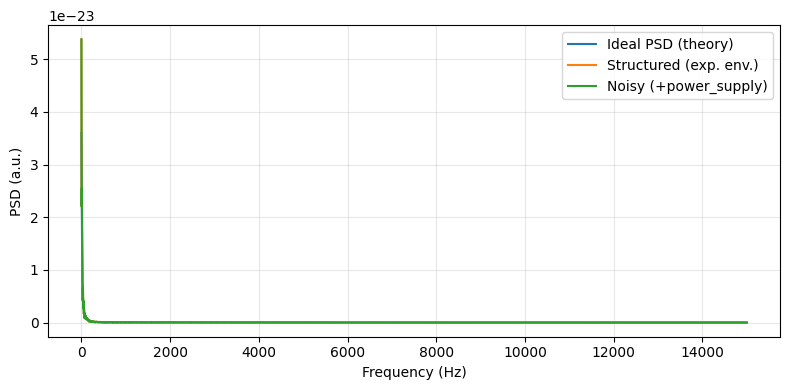

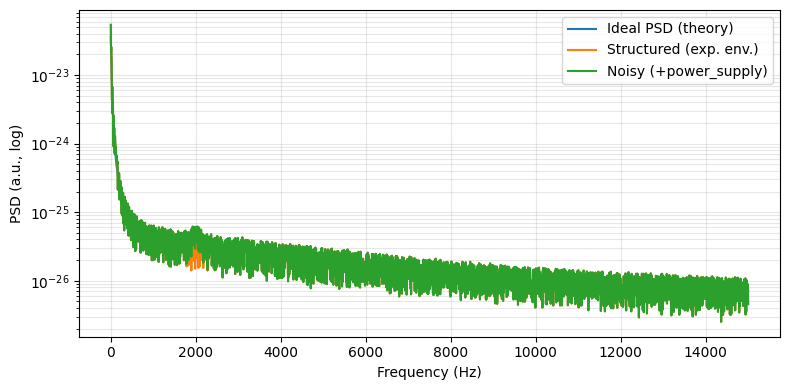

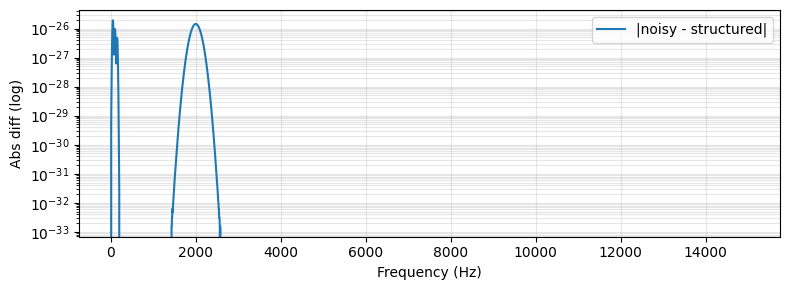

In [ ]:
############################################################
# 図1用：理想PSD → 実験環境ノイズ(structured) → 外的ノイズ(noisy)
############################################################
import pickle
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

# =========================================================
# 0) あなたの既存関数（ここは“すでに定義済み”前提）
#  - add_structured_noise(psd_data, clip_range, smoothing_factor)
#  - add_noise_to_interval(psd_data, interval_idx, noise_type, noise_level, freq_min, freq_max)
# =========================================================
# ※ このセルの上に、あなたが貼った関数定義を置いてください

# =========================================================
# 1) 入力（理想PSDのpickle）
# =========================================================
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"

# 周波数軸
FREQ_MIN = 0.0
FREQ_MAX = 15000.0

# 実験環境ノイズ（structured）パラメータ
STRUCT_CLIP = 0.5
STRUCT_SMOOTH = 0.1

# 外的ノイズ（電源/干渉/クロック）パラメータ
NOISE_TYPE = "power_supply"     # "interference" / "clock_leakage" もOK
NOISE_LEVEL = 0.3               # 例：0.1〜0.5くらいで調整

# 可視化したいサンプル番号
SAMPLE_IDX = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================================================
# 2) 理想PSDを読み込む
# =========================================================
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

if isinstance(data, dict):
    X = np.asarray(data["x"], dtype=np.float32)
else:
    X = np.asarray(data, dtype=np.float32)

# (N,1,L) -> (N,L)
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)
assert X.ndim == 2, f"Unexpected shape: {X.shape}"

N, L = X.shape
print("Loaded PSD:", X.shape)

clean = X[SAMPLE_IDX]
clean = np.nan_to_num(clean, nan=0.0, posinf=0.0, neginf=0.0)
clean_t = torch.from_numpy(clean).to(device)  # (L,)

# 周波数軸（描画用）
freq = torch.linspace(FREQ_MIN, FREQ_MAX, L, device=device)

# =========================================================
# 3) 実験環境ノイズ（構造化ノイズ）を付与 → structured
# =========================================================
structured_t = add_structured_noise(
    clean_t,
    clip_range=STRUCT_CLIP,
    smoothing_factor=STRUCT_SMOOTH
)

# =========================================================
# 4) 外的ノイズをさらに付与 → noisy
# =========================================================
noisy_t, _, _ = add_noise_to_interval(
    structured_t,
    interval_idx=0,
    noise_type=NOISE_TYPE,
    noise_level=NOISE_LEVEL,
    freq_min=FREQ_MIN,
    freq_max=FREQ_MAX,
)

# =========================================================
# 5) 図1：3本を重ね描き（PSDはlog表示が多いので両方用意）
# =========================================================
def safe_np(x):
    x = x.detach().float().cpu().numpy()
    x = np.maximum(x, 1e-30)  # log対策
    return x

freq_np = freq.detach().cpu().numpy()
clean_np = safe_np(clean_t)
structured_np = safe_np(structured_t)
noisy_np = safe_np(noisy_t)

# ---- (A) 線形軸 ----
plt.figure(figsize=(8, 4))
plt.plot(freq_np, clean_np, label="Ideal PSD (theory)")
plt.plot(freq_np, structured_np, label="Structured (exp. env.)")
plt.plot(freq_np, noisy_np, label=f"Noisy (+{NOISE_TYPE})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (a.u.)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---- (B) 対数軸（PSDっぽい見た目） ----
plt.figure(figsize=(8, 4))
plt.plot(freq_np, clean_np, label="Ideal PSD (theory)")
plt.plot(freq_np, structured_np, label="Structured (exp. env.)")
plt.plot(freq_np, noisy_np, label=f"Noisy (+{NOISE_TYPE})")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (a.u., log)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 6) （任意）差分も見たい場合：どこにノイズが乗ったか
# =========================================================
plt.figure(figsize=(8, 3))
plt.plot(freq_np, np.abs(noisy_np - structured_np), label="|noisy - structured|")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Abs diff (log)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


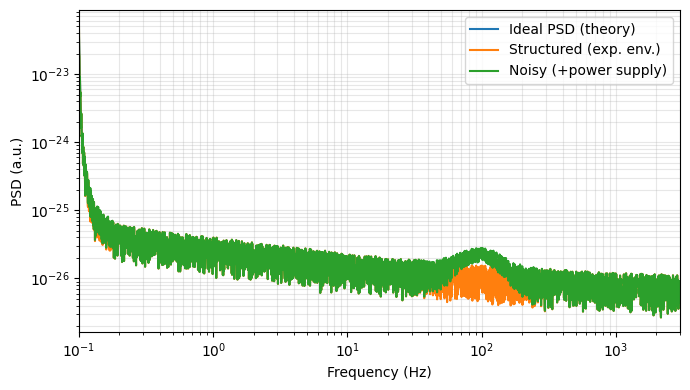

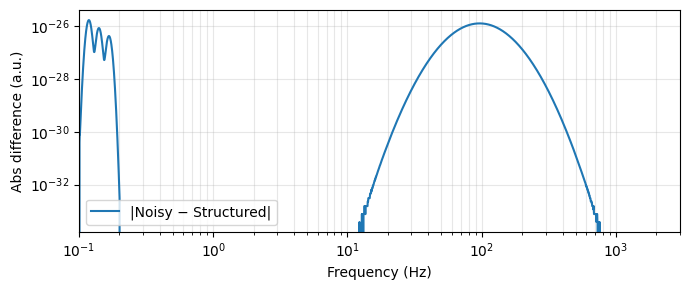

In [ ]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# =========================================================
# 設定
# =========================================================
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"

FREQ_MIN = 1e-1      # log軸用（0回避）
FREQ_MAX = 3000.0    # ← 理論PSDの上限に合わせる

STRUCT_CLIP = 0.5
STRUCT_SMOOTH = 0.1

NOISE_TYPE = "power_supply"
NOISE_LEVEL = 0.3

SAMPLE_IDX = 0

device = torch.device("cpu")

# =========================================================
# PSD 読み込み
# =========================================================
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)

clean = X[SAMPLE_IDX]
clean = np.nan_to_num(clean, nan=0.0, posinf=0.0, neginf=0.0)
clean_t = torch.from_numpy(clean).to(device)

L = clean_t.numel()

# =========================================================
# 周波数軸（log, 0–3000 Hz）
# =========================================================
freq = torch.logspace(
    np.log10(FREQ_MIN),
    np.log10(FREQ_MAX),
    steps=L,
    device=device
)

# =========================================================
# ノイズ付与
# =========================================================
structured_t = add_structured_noise(
    clean_t,
    clip_range=STRUCT_CLIP,
    smoothing_factor=STRUCT_SMOOTH
)

noisy_t, _, _ = add_noise_to_interval(
    structured_t,
    interval_idx=0,
    noise_type=NOISE_TYPE,
    noise_level=NOISE_LEVEL,
    freq_min=FREQ_MIN,
    freq_max=FREQ_MAX,
)

# =========================================================
# numpy化（log安全）
# =========================================================
def safe(x):
    x = x.detach().cpu().numpy()
    return np.maximum(x, 1e-30)

freq_np = freq.cpu().numpy()
clean_np = safe(clean_t)
structured_np = safe(structured_t)
noisy_np = safe(noisy_t)

# =========================================================
# 図1(a)：PSD（横log・縦log）
# =========================================================
plt.figure(figsize=(7,4))
plt.plot(freq_np, clean_np, label="Ideal PSD (theory)")
plt.plot(freq_np, structured_np, label="Structured (exp. env.)")
plt.plot(freq_np, noisy_np, label="Noisy (+power supply)")

plt.xscale("log")
plt.yscale("log")
plt.xlim(FREQ_MIN, FREQ_MAX)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (a.u.)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 図1(b)：外的ノイズ差分
# =========================================================
plt.figure(figsize=(7,3))
plt.plot(freq_np, np.abs(noisy_np - structured_np),
         label="|Noisy − Structured|")

plt.xscale("log")
plt.yscale("log")
plt.xlim(FREQ_MIN, FREQ_MAX)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Abs difference (a.u.)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


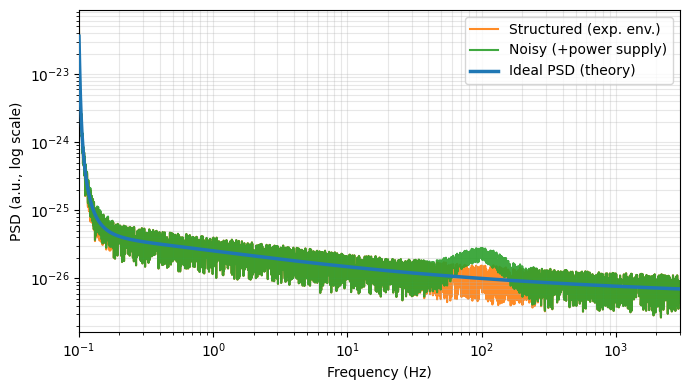

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 念のため log 安全化 =====
def safe(x):
    return np.maximum(x, 1e-30)

freq_np = freq_np          # すでに logspace で作った周波数軸
clean_np = safe(clean_np)
structured_np = safe(structured_np)
noisy_np = safe(noisy_np)

# =========================================================
# 縦軸・横軸ともに log の PSD 図
# =========================================================
plt.figure(figsize=(7, 4))

# 先に下に来てほしいものから描く
plt.plot(
    freq_np, structured_np,
    label="Structured (exp. env.)",
    color="tab:orange",
    zorder=1,
    alpha=0.9
)

plt.plot(
    freq_np, noisy_np,
    label="Noisy (+power supply)",
    color="tab:green",
    zorder=2,
    alpha=0.9
)

# ★ 最後に Ideal PSD（青）を描く
plt.plot(
    freq_np, clean_np,
    label="Ideal PSD (theory)",
    color="tab:blue",
    zorder=3,          # ← 一番大きく
    linewidth=2.5      # ← 少し太くするとさらに見やすい
)

# log-log
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-1, 3e3)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (a.u., log scale)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Device: cpu
Loaded PSD: (32000, 3000)
norm_mean: -3.001098394393921
norm_std : 0.7284296154975891


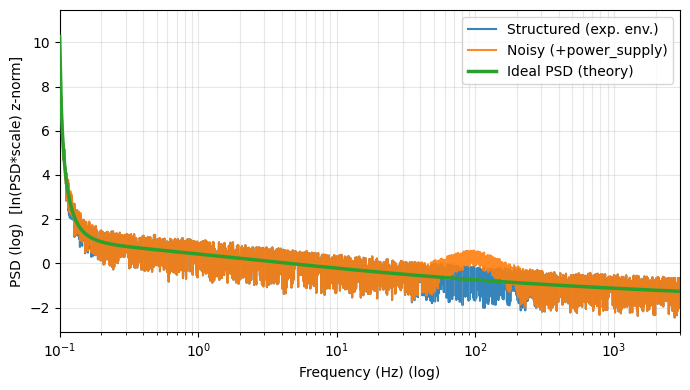

In [ ]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# =========================================================
# 設定
# =========================================================
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
SAMPLE_IDX  = 100

# 周波数軸（2枚目っぽく広めにしたいなら 15000、理論に合わせるなら 3000）
FREQ_MIN = 1e-1
FREQ_MAX = 3000.0   # ←理論に合わせるなら 3000 / 2枚目に寄せるなら 15000

# 環境ノイズ（structured）
STRUCT_CLIP   = 0.5
STRUCT_SMOOTH = 0.1

# 外的ノイズ
NOISE_TYPE  = "power_supply"
NOISE_LEVEL = 0.3

# ★前処理（NoisePointDataset と同じ）
SCALE_FACTOR = 2.5e24    # dataset.scale_factor と同じ

# 正規化統計：2枚目に合わせたいなら「学習時の mean/std」を使うのがベスト
# ここでは「全データから計算」する版（簡単＆再現性あり）
USE_DATASET_STATS = True
STATS_SAMPLES_FOR_EST = 1000  # stats計算に使うサンプル数（重い場合は減らす）

device = torch.device("cpu")
print("Device:", device)

# =========================================================
# 1) PSD 読み込み
# =========================================================
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)
assert X.ndim == 2

N, L = X.shape
print("Loaded PSD:", X.shape)

# =========================================================
# 2) 周波数軸（logspace）
# =========================================================
freq = np.logspace(np.log10(FREQ_MIN), np.log10(FREQ_MAX), L)

# =========================================================
# 3) mean/std を「log space」で推定（NoisePointDatasetと同じ発想）
# =========================================================
def compute_log_stats(X, scale_factor=SCALE_FACTOR, num_samples=1000, seed=42):
    rng = np.random.RandomState(seed)
    n = X.shape[0]
    k = min(num_samples, n)
    idxs = rng.choice(n, size=k, replace=False)

    logs = []
    for i in idxs:
        y = np.nan_to_num(X[i], nan=0.0, posinf=0.0, neginf=0.0)
        y = np.maximum(y * scale_factor, 1e-30)
        logs.append(np.log(y))  # ★ln
    all_log = np.concatenate(logs, axis=0)
    mean = float(all_log.mean())
    std  = float(all_log.std())
    if std < 1e-6:
        std = 1.0
    return mean, std

if USE_DATASET_STATS:
    norm_mean, norm_std = compute_log_stats(X, num_samples=STATS_SAMPLES_FOR_EST)
else:
    norm_mean, norm_std = 0.0, 1.0  # 正規化しない場合

print("norm_mean:", norm_mean)
print("norm_std :", norm_std)

# =========================================================
# 4) 対象サンプル（clean）→ structured → noisy
#    ※ add_structured_noise, add_noise_to_interval は事前定義済み前提
# =========================================================
clean = np.nan_to_num(X[SAMPLE_IDX], nan=0.0, posinf=0.0, neginf=0.0)
clean_t = torch.from_numpy(clean).to(device)

structured_t = add_structured_noise(
    clean_t,
    clip_range=STRUCT_CLIP,
    smoothing_factor=STRUCT_SMOOTH
)

noisy_t, _, _ = add_noise_to_interval(
    structured_t,
    interval_idx=0,
    noise_type=NOISE_TYPE,
    noise_level=NOISE_LEVEL,
    freq_min=FREQ_MIN,
    freq_max=FREQ_MAX
)

# =========================================================
# 5) ★2枚目と同じ「log→正規化」表現に変換してプロット
# =========================================================
def to_log_norm(arr_t, scale_factor=SCALE_FACTOR, mean=0.0, std=1.0):
    a = arr_t.detach().cpu().numpy().astype(np.float64)
    a = np.maximum(a * scale_factor, 1e-30)
    loga = np.log(a)  # ★ln（2枚目がlog10なら np.log10 に変えてOK）
    norm = (loga - mean) / (std + 1e-8)
    return norm

clean_y      = to_log_norm(clean_t, mean=norm_mean, std=norm_std)
structured_y = to_log_norm(structured_t, mean=norm_mean, std=norm_std)
noisy_y      = to_log_norm(noisy_t, mean=norm_mean, std=norm_std)

plt.figure(figsize=(7,4))

# 下にしたい順に描く
plt.plot(freq, structured_y, label="Structured (exp. env.)", zorder=1, alpha=0.9)
plt.plot(freq, noisy_y,      label=f"Noisy (+{NOISE_TYPE})", zorder=2, alpha=0.9)

# ★理論を最前面
plt.plot(freq, clean_y, label="Ideal PSD (theory)", zorder=3, linewidth=2.5)

plt.xscale("log")
plt.xlim(FREQ_MIN, FREQ_MAX)

# 2枚目に合わせて「縦軸は log値そのもの」なので yscale は不要
plt.xlabel("Frequency (Hz) (log)")
plt.ylabel("PSD (log)  [ln(PSD*scale) z-norm]")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 前提：以下の関数はあなたの定義をそのまま使う
#   - add_structured_noise(psd_data, clip_range, smoothing_factor)
#   - add_noise_to_interval(psd_data, interval_idx, noise_type, noise_level, freq_min, freq_max)
# ---------------------------------------------------------

def plot_psd_generation_only(
    idx: int,
    pickle_path: str,
    noise_type: str = "power_supply",     # "power_supply" / "interference" / "clock_leakage"
    noise_level: float = 0.3,
    clip_range: float = 0.5,
    smoothing_factor: float = 0.1,
    scale_factor: float = 2.5e24,         # dataset.scale_factor と一致
    freq_min: float = 0.0,
    freq_max: float = 15000.0,
    x_axis_log: bool = True,              # 2枚目に合わせて log
    use_external_noise: bool = True,      # 図1で外的ノイズも見せるなら True
):
    """
    図1用：
      - Ideal PSD (theory) = pickleの元PSD
      - Structured (exp. env.) = 実験環境ノイズ（構造化ノイズ）を付与したPSD
      - Noisy (external) = さらに外的ノイズを付与したPSD（任意）
    ※ ノイズ検知・再構成は一切しない
    """

    # =========================
    # 1) load PSD
    # =========================
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
    if X.ndim == 3 and X.shape[1] == 1:
        X = X.squeeze(1)
    assert X.ndim == 2, f"Expected (N,L) got {X.shape}"

    base_psd = X[idx].astype(np.float32)
    base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)

    base_t = torch.from_numpy(base_psd)

    L = base_t.numel()

    # =========================
    # 2) freq axis（あなたの可視化と同じ：linspace）
    # =========================
    freqs = torch.linspace(freq_min, freq_max, L).cpu().numpy()

    # log軸にするなら 0Hz は使えないので下限だけ小さく上げる
    if x_axis_log and freqs[0] == 0.0:
        freqs = freqs.copy()
        freqs[0] = 1e-1  # 0回避（見た目はほぼ同じ）

    # =========================
    # 3) generate structured / noisy
    # =========================
    structured_t = add_structured_noise(
        base_t,
        clip_range=clip_range,
        smoothing_factor=smoothing_factor
    )

    if use_external_noise:
        noisy_t, _, _ = add_noise_to_interval(
            structured_t,
            interval_idx=0,
            noise_type=noise_type,
            noise_level=noise_level,
            freq_min=freq_min,
            freq_max=freq_max
        )
    else:
        noisy_t = None

    # =========================
    # 4) y-axis: log(PSD*scale_factor) をそのまま描く（2枚目と一致）
    # =========================
    def to_log(arr_t):
        a = arr_t.detach().cpu().numpy().astype(np.float64)
        a = np.maximum(a * scale_factor, 1e-30)
        return np.log(a)  # ★あなたの visualize と同じ（ln）

    base_log = to_log(base_t)
    structured_log = to_log(structured_t)
    noisy_log = to_log(noisy_t) if noisy_t is not None else None

    # =========================
    # 5) plot
    # =========================
    plt.figure(figsize=(10, 5))

    # structured / noisy を先に描いて、理論線を上に
    plt.plot(freqs, structured_log, label="Structured (exp. env.)", linewidth=1.2, alpha=0.9)
    if noisy_log is not None:
        plt.plot(freqs, noisy_log, label=f"Noisy (+{noise_type})", linewidth=1.2, alpha=0.9)

    plt.plot(freqs, base_log, label="Ideal PSD (theory)", linewidth=2.5, zorder=5)

    if x_axis_log:
        plt.xscale("log")
        plt.xlabel("Frequency [Hz] (log)")
    else:
        plt.xlabel("Frequency [Hz]")

    plt.ylabel("PSD (log)")  # ln(PSD*scale)
    plt.title(f"PSD generation (idx={idx}, L={L})")
    plt.grid(True, which="both", linestyle=":", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


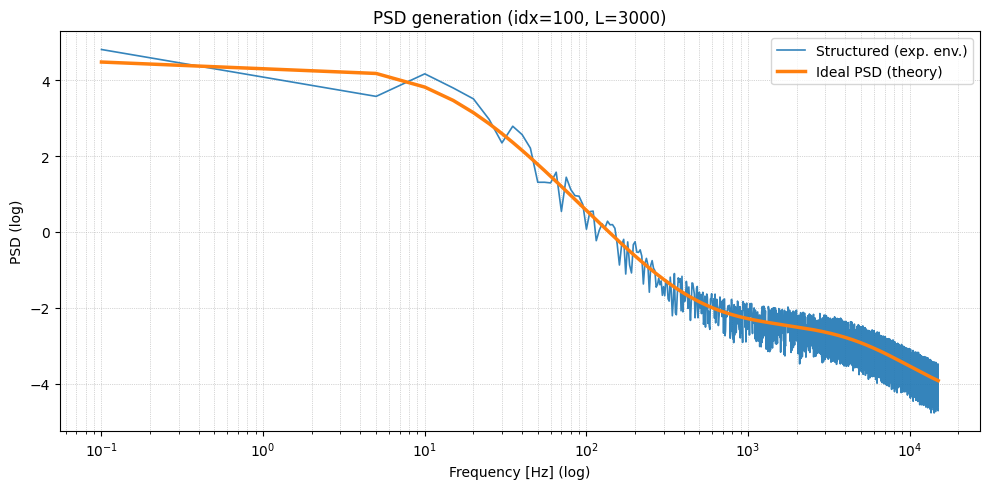

In [ ]:
plot_psd_generation_only(
    idx=100,
    pickle_path="/content/drive/MyDrive/data_lowF_noise.pickle",
    use_external_noise=False,   # ← 外的ノイズは描かない
    freq_min=0.0,
    freq_max=15000.0,
    x_axis_log=True
)


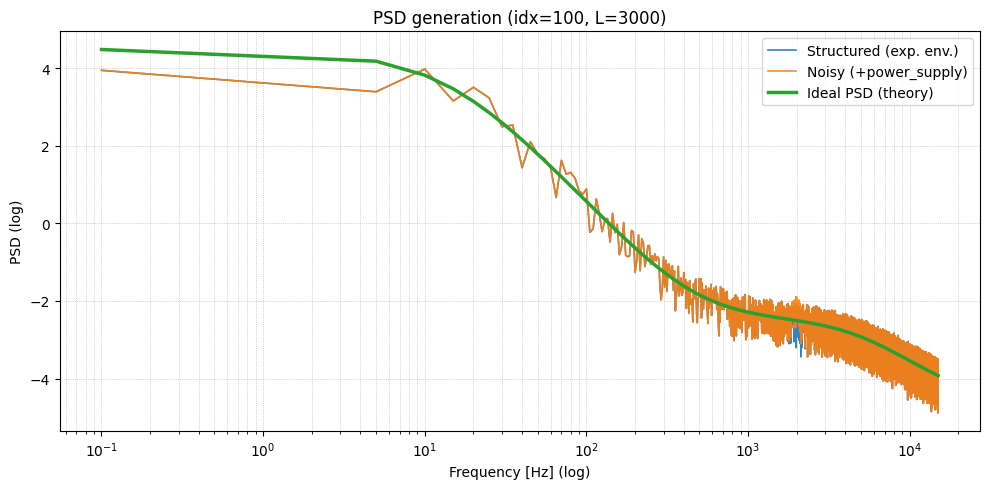

In [ ]:
plot_psd_generation_only(
    idx=100,
    pickle_path="/content/drive/MyDrive/data_lowF_noise.pickle",
    use_external_noise=True,
    noise_type="power_supply",
    noise_level=0.3,
    freq_min=0.0,
    freq_max=15000.0,
    x_axis_log=True
)


In [ ]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# 前提：
# add_structured_noise(...)
# add_noise_to_interval(...)

def plot_psd_three_noises(
    idx: int,
    pickle_path: str,
    noise_level: float = 0.3,
    scale_factor: float = 2.5e24,
    freq_min: float = 0.0,
    freq_max: float = 15000.0,
    x_axis_log: bool = True,
    use_structured: bool = True,
    clip_range: float = 0.5,
    smoothing_factor: float = 0.1,
    show_individual: bool = True,
):
    """
    Ideal PSD（オレンジ）と、実験環境ノイズ込みの外的ノイズPSDのみを可視化。
    Structured 単体の線は描画しない。
    """

    # =========================
    # 1) load PSD
    # =========================
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
    if X.ndim == 3 and X.shape[1] == 1:
        X = X.squeeze(1)
    assert X.ndim == 2, f"Expected (N,L) got {X.shape}"

    base_psd = np.nan_to_num(X[idx].astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    base_t = torch.from_numpy(base_psd)
    L = base_t.numel()

    # =========================
    # 2) freq axis
    # =========================
    freqs = torch.linspace(freq_min, freq_max, L).cpu().numpy()
    if x_axis_log and freqs[0] == 0.0:
        freqs = freqs.copy()
        freqs[0] = 1e-1

    # =========================
    # 3) structured noise（内部で使用のみ）
    # =========================
    if use_structured:
        structured_t = add_structured_noise(
            base_t,
            clip_range=clip_range,
            smoothing_factor=smoothing_factor
        )
        src_t = structured_t
    else:
        structured_t = None
        src_t = base_t

    # =========================
    # 4) external noises
    # =========================
    noise_types = ["power_supply", "interference", "clock_leakage"]
    noisy_dict = {}

    for nt in noise_types:
        noisy_t, _, _ = add_noise_to_interval(
            src_t,
            interval_idx=0,
            noise_type=nt,
            noise_level=noise_level,
            freq_min=freq_min,
            freq_max=freq_max
        )
        noisy_dict[nt] = noisy_t

    # =========================
    # 5) ln(PSD * scale_factor)
    # =========================
    def to_ln_psd(arr_t):
        a = arr_t.detach().cpu().numpy().astype(np.float64)
        a = np.maximum(a * scale_factor, 1e-30)
        return np.log(a)

    base_ln = to_ln_psd(base_t)
    noisy_ln = {k: to_ln_psd(v) for k, v in noisy_dict.items()}

    # =========================
    # 6) overlay plot（配色調整）
    # =========================
    plt.figure(figsize=(10, 5))

    plt.plot(freqs, noisy_ln["power_supply"],
             color="tab:red", linewidth=1.3,
             label="Noisy (env + power supply)")

    plt.plot(freqs, noisy_ln["interference"],
             color="tab:blue", linewidth=1.3,
             label="Noisy (env + interference 3 kHz)")

    plt.plot(freqs, noisy_ln["clock_leakage"],
             color="tab:purple", linewidth=1.3,
             label="Noisy (env + clock leakage 5 kHz)")

    # ★ 元PSDはオレンジに戻す
    plt.plot(freqs, base_ln,
             color="tab:orange", linewidth=2.6,
             label="Ideal PSD (theory)", zorder=5)

    if x_axis_log:
        plt.xscale("log")
        plt.xlabel("Frequency [Hz] (log)")
    else:
        plt.xlabel("Frequency [Hz]")

    plt.ylabel("ln(PSD × scale factor)")
    plt.title(f"Ideal vs Noisy (env included) (idx={idx}, L={L})")

    plt.grid(False)
    plt.tick_params(which="both", direction="in", top=True, right=True)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # =========================
    # 7) individual plots
    # =========================
    if show_individual:
        color_map = {
            "power_supply": "tab:red",
            "interference": "tab:blue",
            "clock_leakage": "tab:purple",
        }

        for nt in noise_types:
            plt.figure(figsize=(10, 5))

            plt.plot(freqs, noisy_ln[nt],
                     color=color_map[nt], linewidth=1.3,
                     label=f"Noisy (env + {nt})")

            plt.plot(freqs, base_ln,
                     color="tab:orange", linewidth=2.6,
                     label="Ideal PSD (theory)", zorder=5)

            if x_axis_log:
                plt.xscale("log")
                plt.xlabel("Frequency [Hz] (log)")
            else:
                plt.xlabel("Frequency [Hz]")

            plt.ylabel("ln(PSD × scale factor)")
            plt.title(f"Ideal vs Noisy (env included): {nt} (idx={idx})")

            plt.grid(False)
            plt.tick_params(which="both", direction="in", top=True, right=True)

            plt.legend()
            plt.tight_layout()
            plt.show()

    return {
        "freqs": freqs,
        "ideal_ln": base_ln,
        "noisy_ln": noisy_ln,
        "ideal_raw": base_t,
        "structured_raw": structured_t,
        "noisy_raw": noisy_dict,
    }


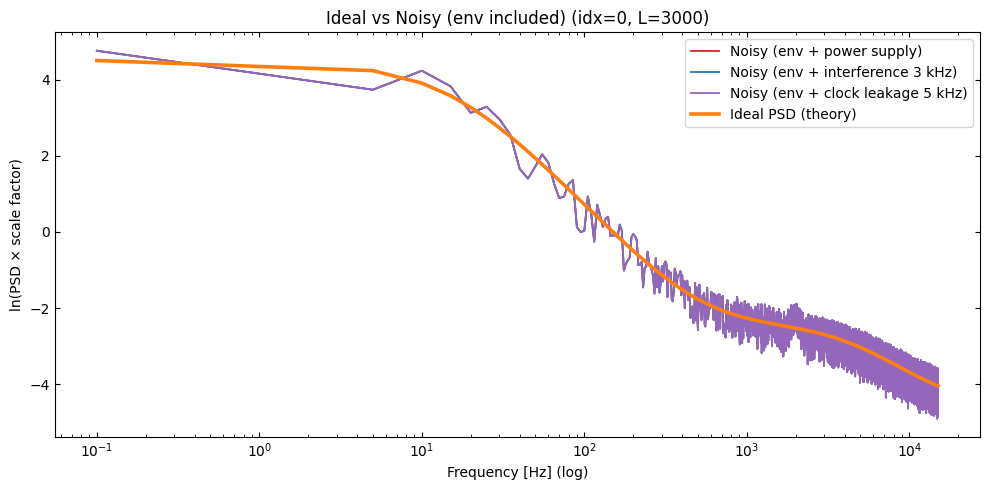

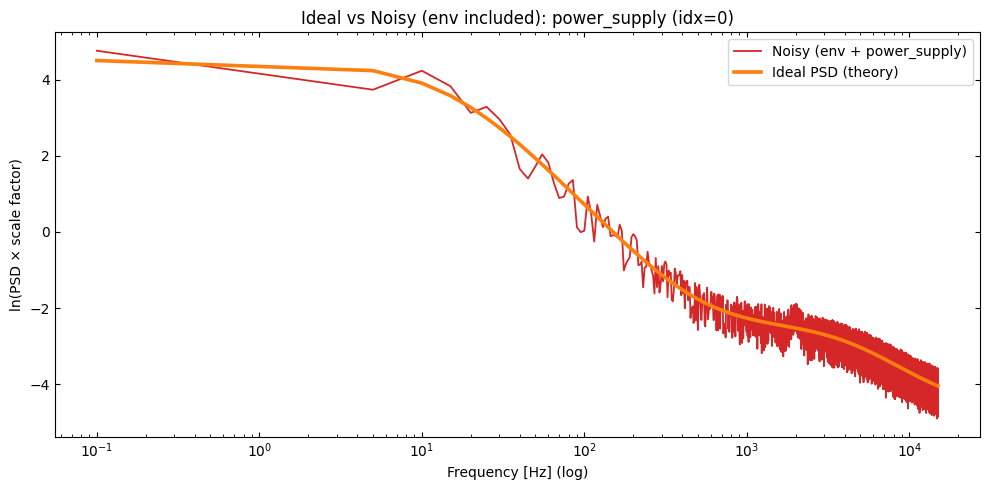

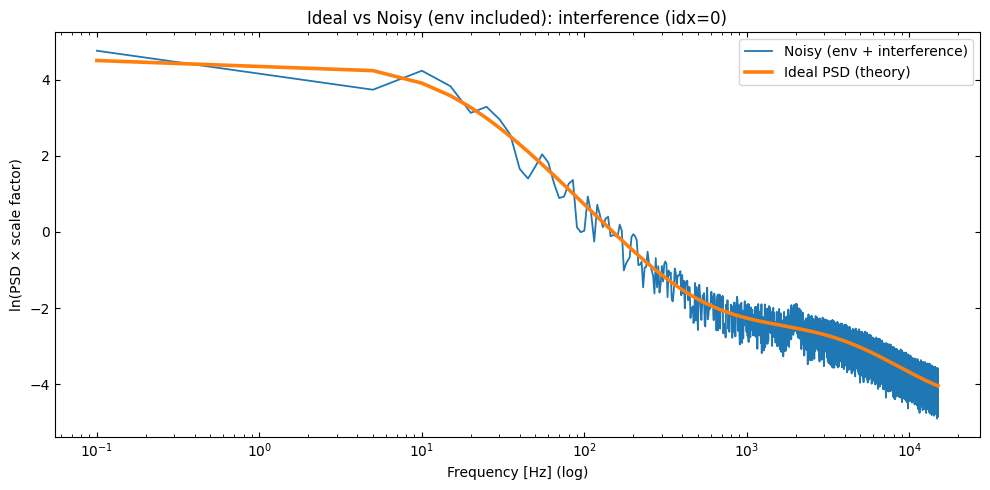

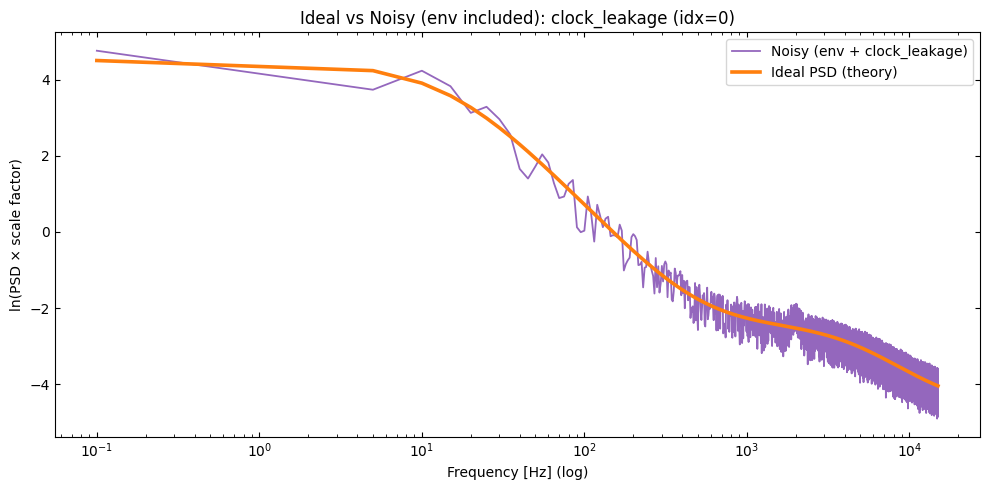

In [ ]:
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"

out = plot_psd_three_noises(
    idx=0,
    pickle_path=PICKLE_PATH,
    noise_level=0.3,
    use_structured=True,
    x_axis_log=True,
    show_individual=True
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 前提：
# plot_psd_three_noises(...) を既に実行できる状態（out を返す）
# out = plot_psd_three_noises(idx=..., pickle_path=..., use_structured=True, show_individual=False)
#
# out["freqs"]      : (L,)
# out["ideal_ln"]   : (L,)
# out["noisy_ln"]   : dict {"power_supply":(L,), "interference":(L,), "clock_leakage":(L,)}

def plot_local_zoom_3panels(
    out: dict,
    windows: dict = None,
    x_axis_log: bool = False,  # 拡大図は線形が見やすいのでデフォFalse
):
    """
    局所拡大図を自動で3枚出す：
      1) power_supply: 50 Hz (±100 Hz くらい)
      2) interference: 3 kHz (±200 Hz くらい)
      3) clock_leakage: 5 kHz (±200 Hz くらい)

    out: plot_psd_three_noises の戻り値
    """

    freqs = np.asarray(out["freqs"])
    ideal = np.asarray(out["ideal_ln"])
    noisy = out["noisy_ln"]

    # デフォルトの拡大範囲（必要なら上書き可）
    if windows is None:
        windows = {
            "power_supply":  (1000, 3000),      # 0〜250 Hz（50/100/150 Hzが入る）
            "interference":  (2000, 4000),  # 3 kHz ±200 Hz
            "clock_leakage": (4000, 7000),  # 5 kHz ±200 Hz
        }

    # 色（さっきの配色に合わせる）
    color_map = {
        "ideal": "tab:orange",
        "power_supply": "tab:red",
        "interference": "tab:blue",
        "clock_leakage": "tab:purple",
    }

    titles = {
        "power_supply": "Zoom: power supply (50/100/150 Hz)",
        "interference": "Zoom: interference (~3 kHz)",
        "clock_leakage": "Zoom: clock leakage (~5 kHz)",
    }

    for nt, (f0, f1) in windows.items():
        mask = (freqs >= f0) & (freqs <= f1)
        if mask.sum() < 5:
            print(f"[WARN] Too few points in window {nt}: {f0}-{f1} Hz (points={mask.sum()})")
            continue

        plt.figure(figsize=(9, 4))

        # noisy（env+外的ノイズ）
        plt.plot(freqs[mask], np.asarray(noisy[nt])[mask],
                 color=color_map[nt], linewidth=1.6, label=f"Noisy (env + {nt})")

        # ideal（理論値）
        plt.plot(freqs[mask], ideal[mask],
                 color=color_map["ideal"], linewidth=2.4, label="Ideal PSD (theory)")

        if x_axis_log:
            # 0Hz 付近は log できないので、power_supply窓を log にする場合は注意
            plt.xscale("log")
            plt.xlabel("Frequency [Hz] (log)")
        else:
            plt.xlabel("Frequency [Hz]")

        plt.ylabel("ln(PSD × scale factor)")
        plt.title(titles.get(nt, f"Zoom: {nt}"))

        # 論文体裁
        plt.grid(False)
        plt.tick_params(which="both", direction="in", top=True, right=True)

        plt.legend()
        plt.tight_layout()
        plt.show()


# =========================
# 使い方（例）
# =========================
# out = plot_psd_three_noises(
#     idx=0,
#     pickle_path="/content/drive/MyDrive/data_lowF_noise.pickle",
#     use_structured=True,
#     show_individual=False  # ← 個別3枚は要らないならFalse
# )
# plot_local_zoom_3panels(out)


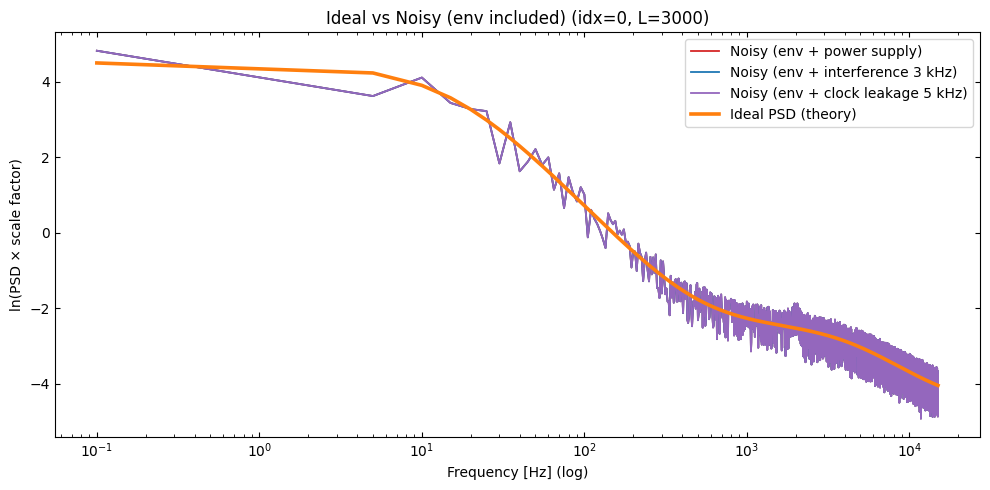

overlay done


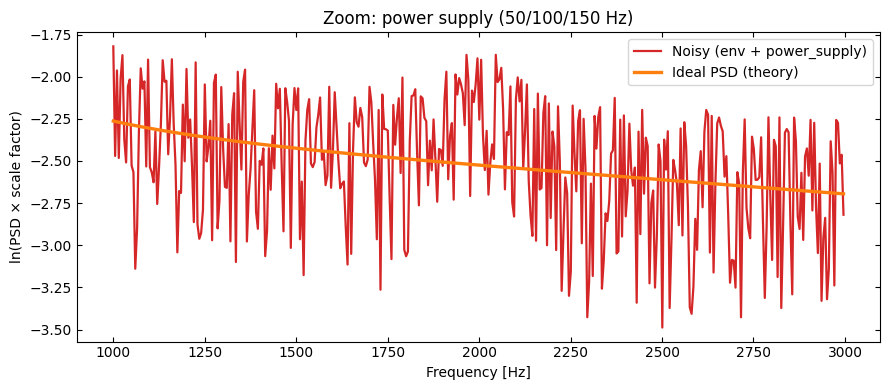

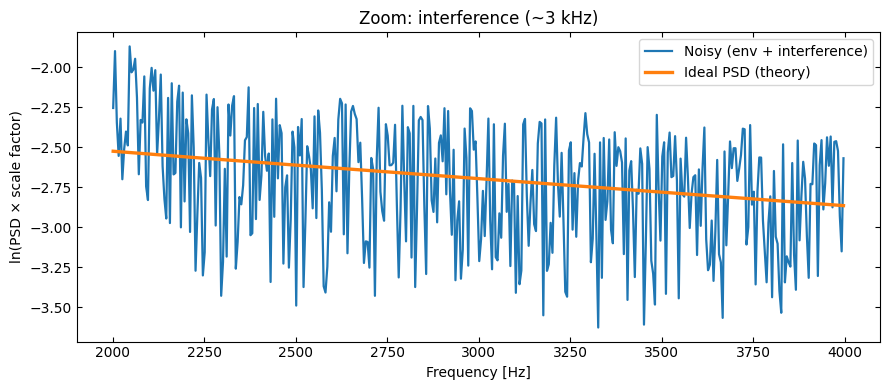

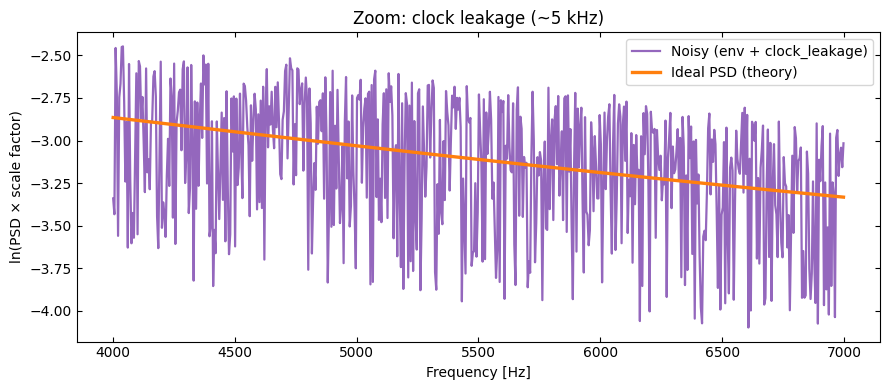

local zoom plots done


In [ ]:
# ============================================
# ① まず overlay 図を1回だけ生成（戻り値 out を作る）
#    ※ 個別3枚は不要なので show_individual=False
# ============================================

PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
IDX = 0

out = plot_psd_three_noises(
    idx=IDX,
    pickle_path=PICKLE_PATH,
    noise_level=0.3,
    use_structured=True,     # 実験環境ノイズは内部で含める
    x_axis_log=True,
    show_individual=False    # ← ここ重要
)

print("overlay done")


# ============================================
# ② 局所拡大図を自動で3枚出す
# ============================================

plot_local_zoom_3panels(out)

print("local zoom plots done")


RUN: plotting...


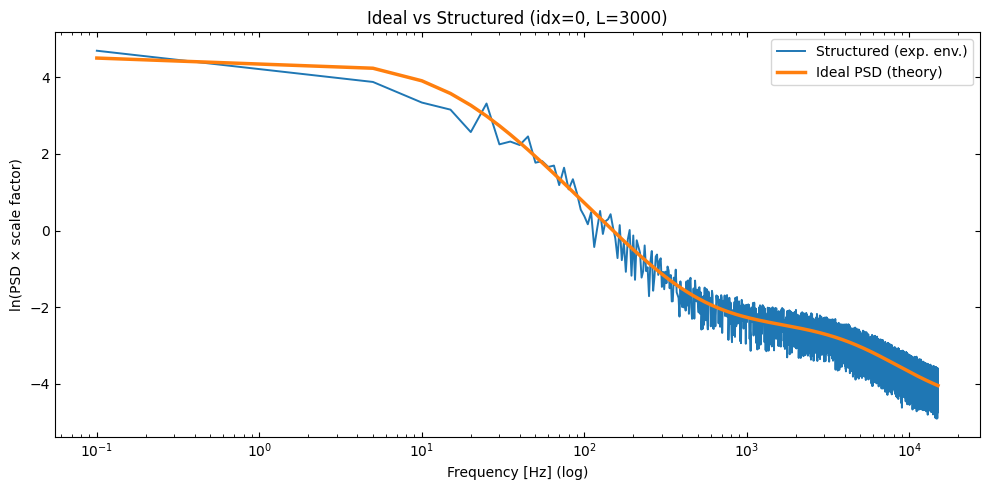

DONE


In [ ]:
# ===== 確実に「グラフが出る」実行コード一式 =====
# Colab / Jupyter 用（.pyでも動く）

import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Colab/Jupyterで図が出ない時の保険（効かない環境もあるが無害） ---
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass


# =========================================================
# 1) 実験環境ノイズ（structured noise）定義（あなたの版）
# =========================================================
def process_noise(noise, clip_range=0.5, smoothing_factor=0.1):
    scaled_noise = noise / clip_range
    processed = torch.tanh(scaled_noise) * clip_range
    smoothed = processed * (1 - smoothing_factor) + noise * smoothing_factor
    return smoothed

def add_structured_noise(psd_data, clip_range=0.5, smoothing_factor=0.1):
    device_local = psd_data.device
    if psd_data.dim() == 1:
        x = psd_data.unsqueeze(0)  # (1, L)
        squeeze_out = True
    else:
        x = psd_data
        squeeze_out = False

    B, L = x.shape

    pos = torch.linspace(1, L, L, device=device_local)
    var = 0.2 + 0.1 * pos / 1000.0
    var = torch.clamp(var, max=0.3)
    std = torch.sqrt(var).unsqueeze(0).expand(B, L)

    noise = torch.normal(mean=0.0, std=std).to(device_local)
    processed = process_noise(noise, clip_range=clip_range, smoothing_factor=smoothing_factor)

    noisy_psd = x * (1.0 + processed)

    if squeeze_out:
        noisy_psd = noisy_psd.squeeze(0)
    return noisy_psd


# =========================================================
# 2) 理論PSD vs structured を描く関数
# =========================================================
def plot_ideal_vs_structured(
    idx: int,
    pickle_path: str,
    clip_range: float = 0.5,
    smoothing_factor: float = 0.1,
    scale_factor: float = 2.5e24,
    freq_min: float = 0.0,
    freq_max: float = 15000.0,
    x_axis_log: bool = True,
):
    # load
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
    if X.ndim == 3 and X.shape[1] == 1:
        X = X.squeeze(1)
    assert X.ndim == 2, f"Expected (N,L) got {X.shape}"

    base_psd = np.nan_to_num(X[idx].astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    ideal_t = torch.from_numpy(base_psd)
    L = ideal_t.numel()

    freqs = torch.linspace(freq_min, freq_max, L).cpu().numpy()
    if x_axis_log and freqs[0] == 0.0:
        freqs = freqs.copy()
        freqs[0] = 1e-1

    structured_t = add_structured_noise(ideal_t, clip_range=clip_range, smoothing_factor=smoothing_factor)

    def to_ln_psd(arr_t: torch.Tensor):
        a = arr_t.detach().cpu().numpy().astype(np.float64)
        a = np.maximum(a * scale_factor, 1e-30)
        return np.log(a)

    ideal_ln = to_ln_psd(ideal_t)
    structured_ln = to_ln_psd(structured_t)

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, structured_ln, label="Structured (exp. env.)", linewidth=1.4)
    plt.plot(freqs, ideal_ln, label="Ideal PSD (theory)", linewidth=2.5, zorder=5)

    if x_axis_log:
        plt.xscale("log")
        plt.xlabel("Frequency [Hz] (log)")
    else:
        plt.xlabel("Frequency [Hz]")

    plt.ylabel("ln(PSD × scale factor)")
    plt.title(f"Ideal vs Structured (idx={idx}, L={L})")

    # 体裁：背景線なし・目盛り内向き
    plt.grid(False)
    plt.tick_params(which="both", direction="in", top=True, right=True)

    plt.legend()
    plt.tight_layout()

    # ★これで強制的に表示（環境によって効く）
    plt.show()
    plt.close()


# =========================================================
# 3) ★実行コード（ここが無いと図は出ない）
# =========================================================
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
IDX = 0

print("RUN: plotting...")
plot_ideal_vs_structured(
    idx=IDX,
    pickle_path=PICKLE_PATH,
    clip_range=0.5,
    smoothing_factor=0.1,
    x_axis_log=True
)
print("DONE")


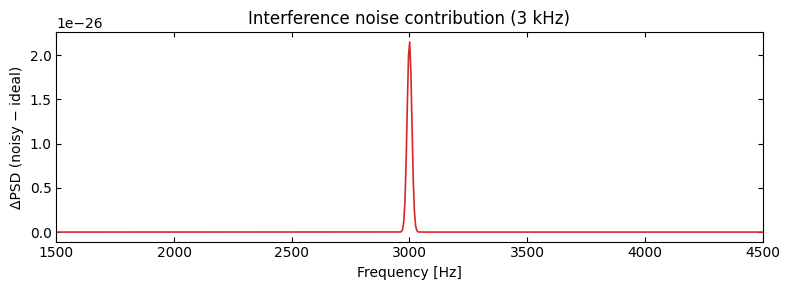

In [ ]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

# =========================
# 設定
# =========================
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
IDX = 0

freq_min = 0.0
freq_max = 15000.0
noise_level = 0.3
scale_factor = 2.5e24   # 可視化用（差分では不要だが一貫性のため）

# =========================
# 干渉ノイズ（3 kHz）定義
# =========================
def add_interference_noise(psd_data, noise_level=0.1,
                           freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    L = psd_data.numel()

    freqs = torch.linspace(freq_min, freq_max, L, device=psd_data.device)
    base_amp = psd_data.mean() * noise_level

    center_freq = 3000.0   # ★ 3 kHz
    sigma = 10.0           # Hz（細いピーク）

    peak = base_amp * torch.exp(-0.5 * ((freqs - center_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data

# =========================
# 1) PSD 読み込み
# =========================
with open(PICKLE_PATH, "rb") as f:
    data = pickle.load(f)

X = np.asarray(data["x"], dtype=np.float32) if isinstance(data, dict) else np.asarray(data, dtype=np.float32)
if X.ndim == 3 and X.shape[1] == 1:
    X = X.squeeze(1)

base_psd = X[IDX]
base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)
base_t = torch.from_numpy(base_psd)

L = base_t.numel()

# 周波数軸（※あくまで仮定）
freqs = torch.linspace(freq_min, freq_max, L).numpy()
freqs[0] = max(freqs[0], 1e-1)  # log表示対策

# =========================
# 2) 干渉ノイズのみ付与
# =========================
noisy_t = add_interference_noise(
    base_t,
    noise_level=noise_level,
    freq_min=freq_min,
    freq_max=freq_max
)

# =========================
# 3) 差分を計算
# =========================
delta = (noisy_t - base_t).detach().cpu().numpy()

# =========================
# 4) 差分プロット（局所拡大）
# =========================
plt.figure(figsize=(8, 3))
plt.plot(freqs, delta, color="tab:red", linewidth=1.2)

plt.xlim(1500, 4500)   # ★ 3 kHz 周辺を拡大
plt.xlabel("Frequency [Hz]")
plt.ylabel("ΔPSD (noisy − ideal)")
plt.title("Interference noise contribution (3 kHz)")

# 論文体裁
plt.grid(False)
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.tight_layout()
plt.show()
